In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix

In [2]:
# helper function to plot results
def plotter(axs, result, cv=1):
    for i, v in enumerate(['loss', 'accuracy']):
        for j in range(cv):
            axs[i].plot(result[f"{v}"], label=f"Training {v.title()}")
            axs[i].plot(result[f"val_{v}"], label=f"Validation {v.title()}")

        axs[i].set_title(f'{v.title()} Across Epochs', fontsize=20)
        axs[i].set_ylabel(f"{v.title()}", fontsize=15)
        axs[i].set_xlabel("Number of Epochs", fontsize=15)
        axs[i].legend(fontsize=10);

In [3]:
def read_dataset():
    
    # read data
    X = pd.read_csv("fashion-mnist_train.csv")
    
    # separate y from X
    y = X.pop('label')

    # reshape the data into 4d numpy array where 
    # the first dimension is the number of samples and the remaining dimensions are of image data
    X = X.values.reshape((len(X), *[int(X.shape[1]**0.5)]*2, 1))
    
    return X, y


def preprocessing(X, y):
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)
    
    # normalize data
    X_train = X_train / 255
    X_test  = X_test / 255
    
    global image_shape
    image_shape = X_train.shape[1:]
    
    return (X_train, y_train), (X_test, y_test)

In [4]:
def build_model():

    model = Sequential()

    model.add(Conv2D(64, 3, activation='relu', input_shape=image_shape))
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(512, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(64, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dense(32, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [5]:
def fit_model(model, train_data, val_data):
    batch = 128
    epochs = 20

    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    check_point = ModelCheckpoint('best_model.h5', save_best_only=True)

    history = model.fit(
        *train_data, 
        validation_data=val_data, 
        epochs=epochs, 
        batch_size=batch,
        callbacks=[early_stopping, check_point]
    )
    
    return model, history

In [16]:
def print_errors(model):
    test, preds = get_predictions(model)
    wrong_ix = preds.index[preds['Truth'] != preds['Predictions']]
    
    for i in wrong_ix[:10]:
        plt.clf()
        plt.imshow(test[i, :, :, 0], 'binary')
        plt.show()
        pred = preds.loc[i, 'Predictions']
        truth = preds.loc[i, 'Truth']
        print(f'We thought = {num_2_item_map[pred]}, but really {num_2_item_map[truth]}')


# helper function that builds predictions
def get_predictions(model):
    test1 = test.values.reshape(len(test), 28, 28, 1)
    df = pd.DataFrame(
            {'Truth': y_test, 
            'Predictions': model.predict(test1, verbose=0).argmax(1)}
        )
    return test1, df

In [7]:
X, y = read_dataset()
train_data, val_data = preprocessing(X, y)
test = pd.read_csv('fashion-mnist_test.csv')
y_test = test.pop('label')
test = test / 255

In [8]:
num_2_item_map = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 
                  3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 
                  7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

The first image is Pullover:


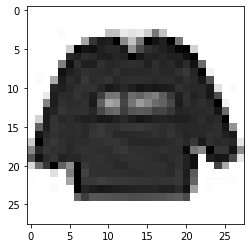

In [9]:
print(f'The first image is {num_2_item_map[y[0]]}:')
plt.imshow(X[0].reshape(28, 28), 'binary');

## Model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                    

In [12]:
model, history = fit_model(model, train_data, val_data)

Epoch 1/20
352/352 [==============================] - 20s 30ms/step - loss: 5.9186 - accuracy: 0.7797 - val_loss: 2.3345 - val_accuracy: 0.1736
Epoch 2/20
352/352 [==============================] - 10s 29ms/step - loss: 0.4966 - accuracy: 0.8695 - val_loss: 0.9510 - val_accuracy: 0.7672
Epoch 3/20
352/352 [==============================] - 13s 36ms/step - loss: 0.4079 - accuracy: 0.8926 - val_loss: 0.5450 - val_accuracy: 0.8664
Epoch 4/20
352/352 [==============================] - 11s 31ms/step - loss: 0.3586 - accuracy: 0.9037 - val_loss: 0.4241 - val_accuracy: 0.8844
Epoch 5/20
352/352 [==============================] - 10s 27ms/step - loss: 0.3197 - accuracy: 0.9170 - val_loss: 0.4905 - val_accuracy: 0.8730
Epoch 6/20
352/352 [==============================] - 10s 28ms/step - loss: 0.2940 - accuracy: 0.9267 - val_loss: 0.3426 - val_accuracy: 0.9121
Epoch 7/20
352/352 [==============================] - 10s 27ms/step - loss: 0.2676 - accuracy: 0.9334 - val_loss: 0.3873 - val_accuracy:

## Model performance

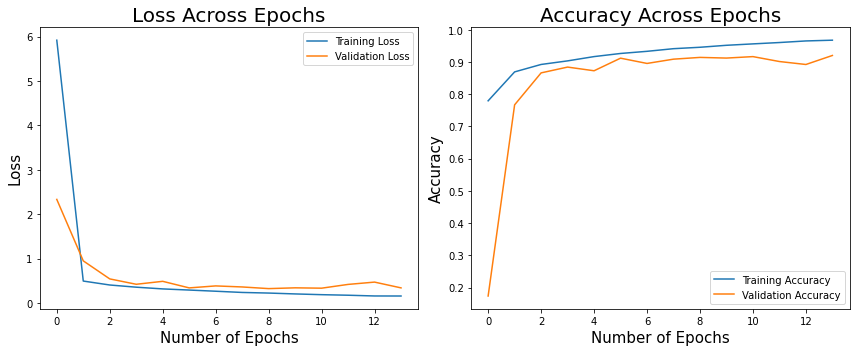

In [13]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
plotter(axs, history.history)
fig.tight_layout();

## Wrong predictions

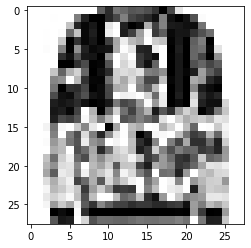

We thought = Shirt, but really Pullover


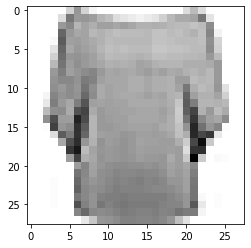

We thought = Shirt, but really Pullover


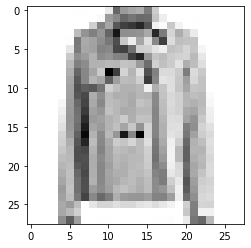

We thought = Pullover, but really Coat


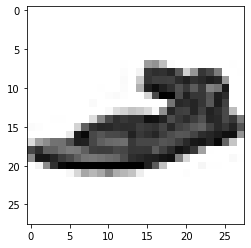

We thought = Sneaker, but really Sandal


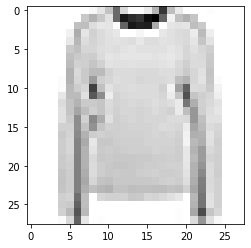

We thought = Shirt, but really Pullover


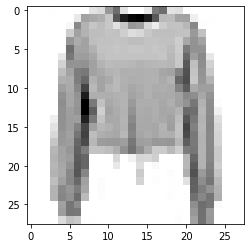

We thought = Shirt, but really Pullover


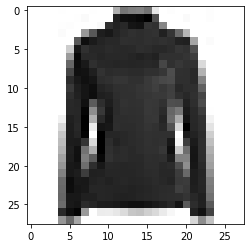

We thought = Coat, but really Pullover


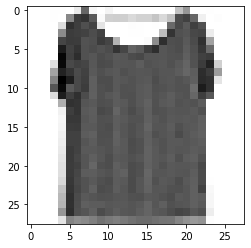

We thought = T-shirt/top, but really Shirt


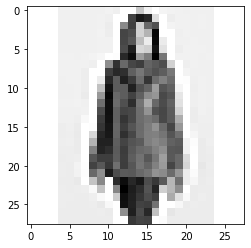

We thought = Shirt, but really Coat


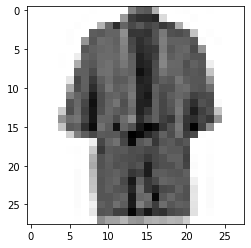

We thought = Shirt, but really Coat


In [17]:
print_errors(model)

## Evaluation

In [22]:
history.history['val_accuracy'][-1]

0.9204666614532471